In [1]:
# ===================================================================
# # 1. Setup & Imports
# This section handles the initial environment setup. It installs all
# required packages silently and creates the necessary project folders.
# ===================================================================
import subprocess
import sys
import os
import glob

print("--- Setting up environment ---")

# Silently install required packages if they are not already present
required_packages = [
    "torch", "torchvision", "timm", "opencv-python", "numpy", "scipy",
    "scikit-learn", "matplotlib", "Pillow", "tqdm", "scikit-image",
    "distinctipy"
]
for pkg in required_packages:
    try:
        __import__(pkg.split('-')[0])
    except ImportError:
        subprocess.run([sys.executable, "-m", "pip", "install", pkg], capture_output=True, check=True)

# Create standard folders for project output
project_folders = ["results", "models", "data", "logs"]
for folder in project_folders:
    os.makedirs(folder, exist_ok=True)

# Import all necessary libraries for the pipeline
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
from torchvision import transforms
import distinctipy

print("--- Environment is ready ---\n")


--- Setting up environment ---
--- Environment is ready ---



In [3]:
# ===================================================================
# # 2. Globals & Configuration
# This section defines all key variables, paths, and settings that
# are used throughout the script for easy modification.
# ===================================================================
# --- Device and Seed Configuration ---
# Set the computation device (GPU if available) and random seeds for reproducibility
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# --- File Paths ---
DATASET_FOLDER = "silk_dataset"

# --- Images for Evaluation ---
# The specific images you requested for testing
TEST_IMAGE_FILENAMES = ["img_2711.jpg", "img_2849.jpg", "img_2868.jpg", "img_3009.jpg"]

print(f"Using device: {DEVICE}")
print(f"Dataset folder set to: '{DATASET_FOLDER}'")
print(f"Images to be tested: {TEST_IMAGE_FILENAMES}\n")

Using device: cuda
Dataset folder set to: 'silk_dataset'
Images to be tested: ['img_2711.jpg', 'img_2849.jpg', 'img_2868.jpg', 'img_3009.jpg']



In [4]:
# ===================================================================
# # 3. Data Loading
# Contains helper functions for finding and loading image data.
# ===================================================================
def find_all_images(dataset_folder):
    """
    Scans a directory for all files with common image extensions.
    """
    exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    image_paths = []
    for ext in exts:
        image_paths.extend(glob.glob(os.path.join(dataset_folder, f"*{ext}")))
        image_paths.extend(glob.glob(os.path.join(dataset_folder, f"*{ext.upper()}")))
    return sorted(list(set(image_paths)))

# For reference, find all images in the dataset folder
all_image_paths = find_all_images(DATASET_FOLDER)
print(f"Found {len(all_image_paths)} total images in '{DATASET_FOLDER}'.\n")



Found 1351 total images in 'silk_dataset'.



In [6]:
# ===================================================================
# # 4. Models and Logic
# This section contains the core classes for the segmentation pipeline,
# including feature extraction, semantic segmentation, and instance segmentation.
# ===================================================================

class DINOFeatureExtractor:
    """
    A wrapper for the DINOv2 model to extract high-level visual features
    from an image. These features are the foundation for the segmentation tasks.
    """
    def __init__(self, model_name='dinov2_vitb14', device='cuda'):
        self.device = device
        print("Initializing DINOv2 model. This may take a moment...")
        self.model = torch.hub.load('facebookresearch/dinov2', model_name, pretrained=True, verbose=False).to(device).eval()
        self.transform = transforms.Compose([
            transforms.Resize((518, 518), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print("DINOv2 Feature Extractor is ready.\n")

    def extract_features(self, image_path):
        """Processes an image and returns its patch features."""
        image = Image.open(image_path).convert('RGB')
        tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            features = self.model.forward_features(tensor)['x_norm_patchtokens']
            # Reshape features into a spatial grid (37x37 patches)
            patches = features.reshape(1, 37, 37, -1)
        return patches.squeeze(0).cpu().numpy()

class SemanticSegmentation:
    """
    Performs semantic segmentation using spectral clustering on DINOv2 features.
    It groups pixels into a predefined number of categories (e.g., silkworms, leaves).
    """
    def __init__(self, tau=0.12, n_classes=3):
        self.tau = tau
        self.n_classes = n_classes
        self.eps = 1e-8

    def _compute_affinity(self, features):
        """Calculates a similarity matrix between all feature patches."""
        H, W, D = features.shape
        X = features.reshape(-1, D)
        X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + self.eps)
        # Create an affinity matrix based on dot product similarity, thresholded by tau
        aff = np.maximum(X_norm @ X_norm.T - self.tau, 0)
        return aff

    def _spectral_clustering(self, aff, target_shape):
        """Groups features into clusters based on the affinity matrix."""
        degree = np.sum(aff, axis=1)
        D_inv_sqrt = np.diag(1.0 / (np.sqrt(degree) + self.eps))
        norm_aff = D_inv_sqrt @ aff @ D_inv_sqrt
        
        # Find the top eigenvectors of the normalized affinity matrix
        _, eigvecs = eigsh(norm_aff, k=self.n_classes, which='LM')
        
        # Resize eigenvectors to match original image dimensions
        H_feat, W_feat = int(np.sqrt(len(aff))), int(np.sqrt(len(aff)))
        eigvecs_reshaped = eigvecs.reshape(H_feat, W_feat, self.n_classes)
        eigvecs_resized = cv2.resize(eigvecs_reshaped, (target_shape[1], target_shape[0]), cv2.INTER_LINEAR)
        
        # Use K-Means to assign final labels
        kmeans = KMeans(n_clusters=self.n_classes, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(eigvecs_resized.reshape(-1, self.n_classes))
        return labels.reshape(target_shape)

    def generate_label_map(self, features, original_image):
        """Generates the raw, unlabeled semantic cluster map for an image."""
        affinity_matrix = self._compute_affinity(features)
        return self._spectral_clustering(affinity_matrix, original_image.shape[:2])

class InstanceSegmentation:
    """
    Identifies and separates individual objects (instances) within a binary mask
    using the watershed algorithm. This is ideal for counting objects like silkworms.
    """
    def __init__(self, min_obj_size=150, min_distance=12):
        self.min_obj_size = min_obj_size
        self.min_distance = min_distance

    def generate_instances(self, binary_mask):
        """
        Takes a binary mask of a single category and returns a list of individual object masks.
        """
        if not np.any(binary_mask):
            return []

        # Remove small, noisy objects from the mask
        cleaned_mask = remove_small_objects(binary_mask.astype(bool), min_size=self.min_obj_size)
        if not np.any(cleaned_mask):
            return []

        # Use distance transform to find peaks, which will serve as markers for the watershed
        distance = ndimage.distance_transform_edt(cleaned_mask)
        coords = peak_local_max(distance, min_distance=self.min_distance, labels=cleaned_mask)
        
        markers_mask = np.zeros(distance.shape, dtype=bool)
        markers_mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(markers_mask)
        
        # Apply the watershed algorithm to separate touching objects
        instance_labels = watershed(-distance, markers, mask=cleaned_mask)
        
        # Extract each unique instance into its own binary mask
        instances = []
        for label_id in np.unique(instance_labels):
            if label_id == 0: continue # Skip the background
            instances.append((instance_labels == label_id).astype(np.uint8))

        return instances

class FinalPipeline:
    """
    The main orchestrator that combines all the models and logic. It runs the full
    end-to-end process: feature extraction -> semantic segmentation -> instance segmentation.
    """
    def __init__(self, extractor, semantic_segmentor, instance_segmentor):
        self.extractor = extractor
        self.semantic_segmentor = semantic_segmentor
        self.instance_segmentor = instance_segmentor

    def run(self, image_path):
        """Executes the complete segmentation pipeline for a given image."""
        original_image = np.array(Image.open(image_path).convert('RGB'))
        features = self.extractor.extract_features(image_path)

        # 1. Get the raw semantic map with N clusters (e.g., 0, 1, 2)
        unlabeled_map = self.semantic_segmentor.generate_label_map(features, original_image)
        
        # 2. Apply a fixed labeling scheme where cluster '0' is assumed to be silkworms.
        # This bypasses the need for automatic color-based labeling.
        label_to_name = {0: 'silkworms'}
        present_labels = list(np.unique(unlabeled_map))
        remaining_names = ['leaves', 'background']
        for label_val in present_labels:
            if label_val != 0 and remaining_names:
                label_to_name[label_val] = remaining_names.pop(0)

        name_to_label = {v: k for k, v in label_to_name.items()}

        # 3. Create a binary mask containing only the pixels labeled as 'silkworms'
        silkworm_label_idx = name_to_label.get('silkworms')
        if silkworm_label_idx is not None:
            silkworm_mask = (unlabeled_map == silkworm_label_idx).astype(np.uint8)
        else:
            silkworm_mask = np.zeros_like(unlabeled_map, dtype=np.uint8)

        # 4. Run instance segmentation on the silkworm mask to count them
        instance_masks = self.instance_segmentor.generate_instances(silkworm_mask)

        return {
            "instance_masks": instance_masks,
            "semantic_map": unlabeled_map,
            "label_to_name_map": label_to_name,
            "silkworm_count": len(instance_masks)
        }

In [7]:

# ===================================================================
# # 5. Visualization
# Utility functions for plotting and displaying the results.
# ===================================================================
def plot_segmentation_visualization(image_path, results):
    """
    Creates and displays a side-by-side comparison of the original image,
    the semantic segmentation, and the final instance segmentation.
    """
    orig = np.array(Image.open(image_path).convert("RGB"))
    
    # --- Create Semantic Segmentation Image ---
    semantic_map = results["semantic_map"]
    label_to_name = results["label_to_name_map"]
    name_to_label = {v: k for k, v in label_to_name.items()}
    # Define colors for each category for consistent visualization
    sem_colors = {'silkworms': [255, 0, 255], 'leaves': [0, 255, 0], 'background': [255, 0, 0]}
    
    semantic_overlay = np.zeros_like(orig, dtype=np.float32)
    for name, color in sem_colors.items():
        if name in name_to_label:
            semantic_overlay[semantic_map == name_to_label[name]] = color
    # Blend the original image with the colored semantic overlay
    semantic_img = cv2.addWeighted((orig / 255.0).astype(np.float32), 0.5, semantic_overlay / 255.0, 0.5, 0)

    # --- Create Instance Segmentation Image ---
    # Draw contours for each detected silkworm on the original image
    instance_img = orig.copy()
    if results["instance_masks"]:
        instance_colors = distinctipy.get_colors(len(results["instance_masks"]))
        for i, mask in enumerate(results["instance_masks"]):
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            color_bgr = [c * 255 for c in instance_colors[i]][::-1] # Convert RGB to BGR for OpenCV
            cv2.drawContours(instance_img, contours, -1, color_bgr, 3) # Use a thicker line
    
    # --- Plot all three images ---
    f, ax = plt.subplots(1, 3, figsize=(21, 7))
    ax[0].imshow(orig); ax[0].set_title(f"Original: {os.path.basename(image_path)}")
    ax[1].imshow(semantic_img); ax[1].set_title("Semantic Segmentation")
    ax[2].imshow(instance_img); ax[2].set_title(f"Instance Segmentation ({results['silkworm_count']} Silkworms)")
    
    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()
W

In [8]:
# ===================================================================
# # 6. Training (Placeholder)
# This section is included for structural consistency. No training is
# needed because this pipeline relies on a pre-trained DINOv2 model.
# ===================================================================
print("--- Training Section ---")
print("This is an unsupervised pipeline. No model training is required.\n")



--- Training Section ---
This is an unsupervised pipeline. No model training is required.



--- Starting Evaluation ---
Initializing DINOv2 model. This may take a moment...


C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DINOv2 Feature Extractor is ready.


Processing image: silk_dataset\img_2711.jpg
Total silkworm instances detected: 154
Semantic labels assigned: {0: 'silkworms', np.int32(1): 'leaves', np.int32(2): 'background'}


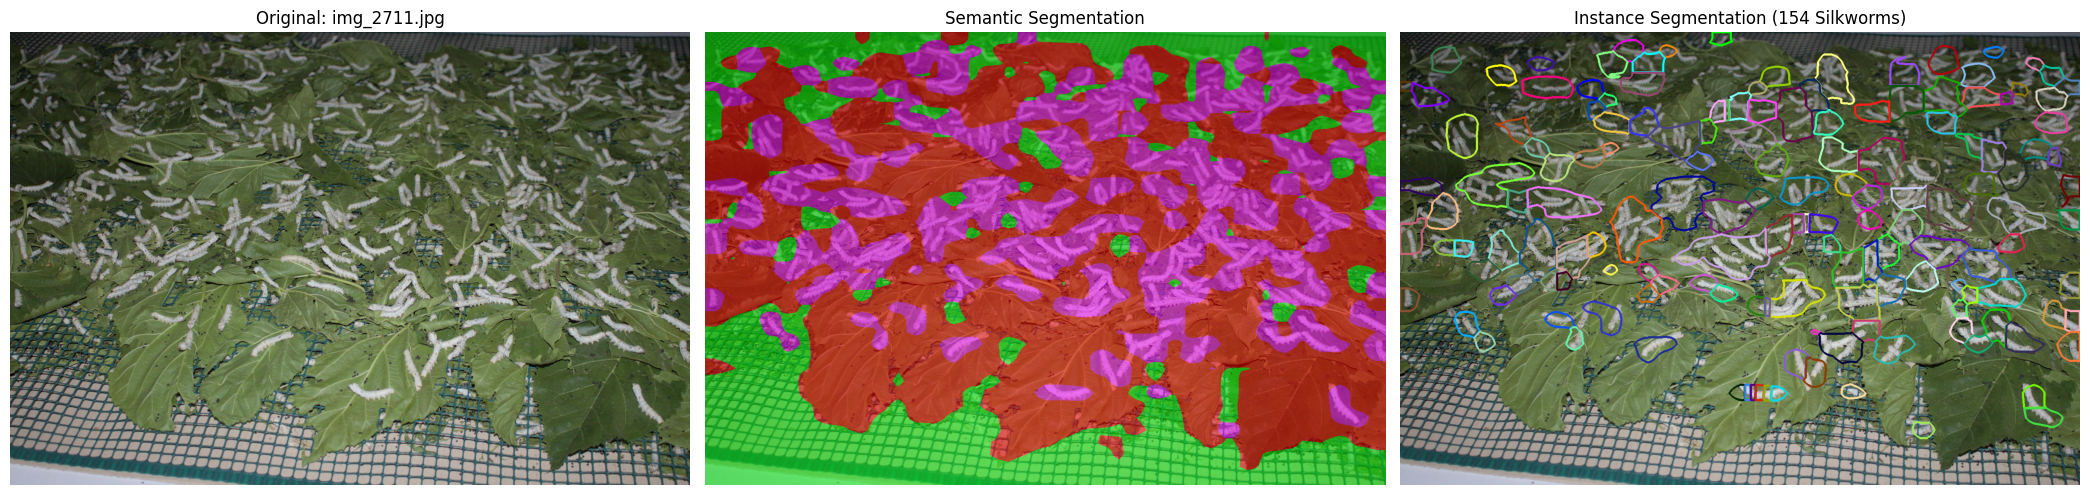


Processing image: silk_dataset\img_2849.jpg
Total silkworm instances detected: 31
Semantic labels assigned: {0: 'silkworms', np.int32(1): 'leaves', np.int32(2): 'background'}


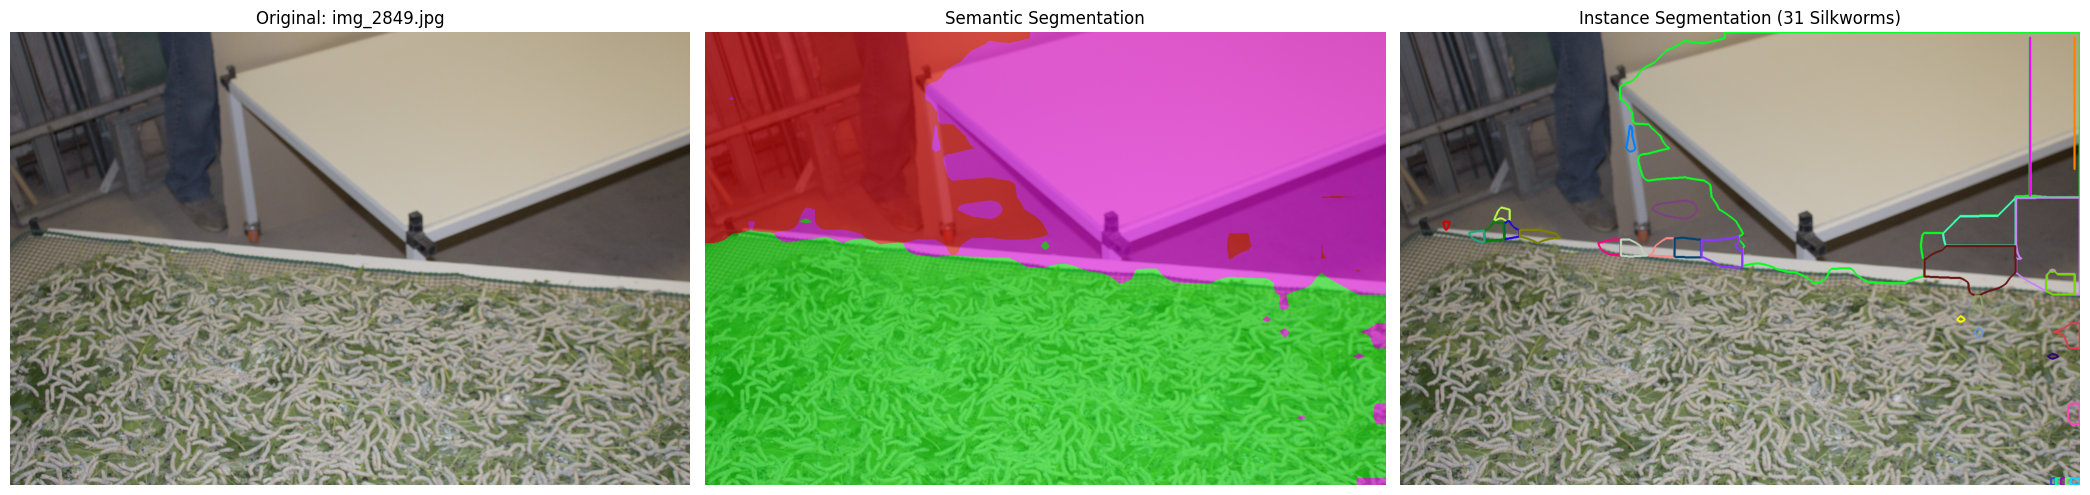


Processing image: silk_dataset\img_2868.jpg
Total silkworm instances detected: 113
Semantic labels assigned: {0: 'silkworms', np.int32(1): 'leaves', np.int32(2): 'background'}


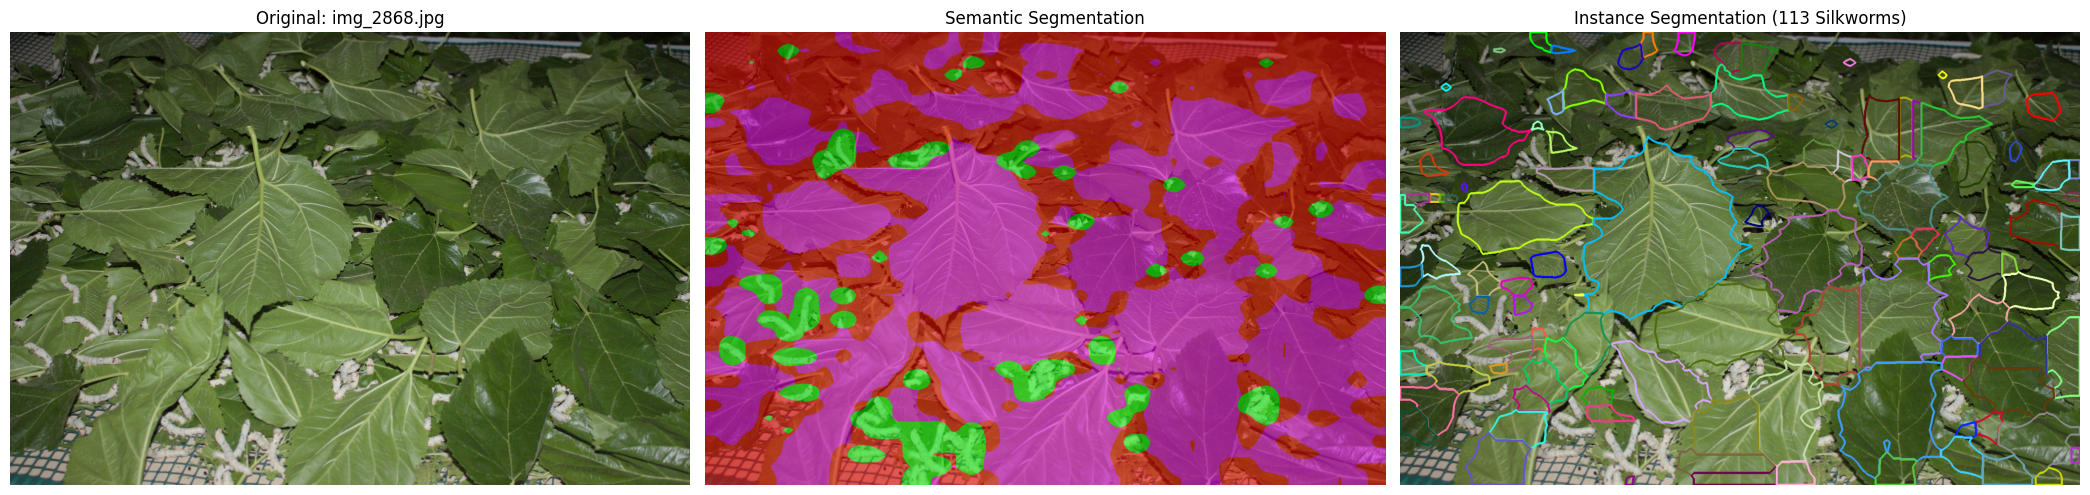


Processing image: silk_dataset\img_3009.jpg
Total silkworm instances detected: 187
Semantic labels assigned: {0: 'silkworms', np.int32(1): 'leaves', np.int32(2): 'background'}


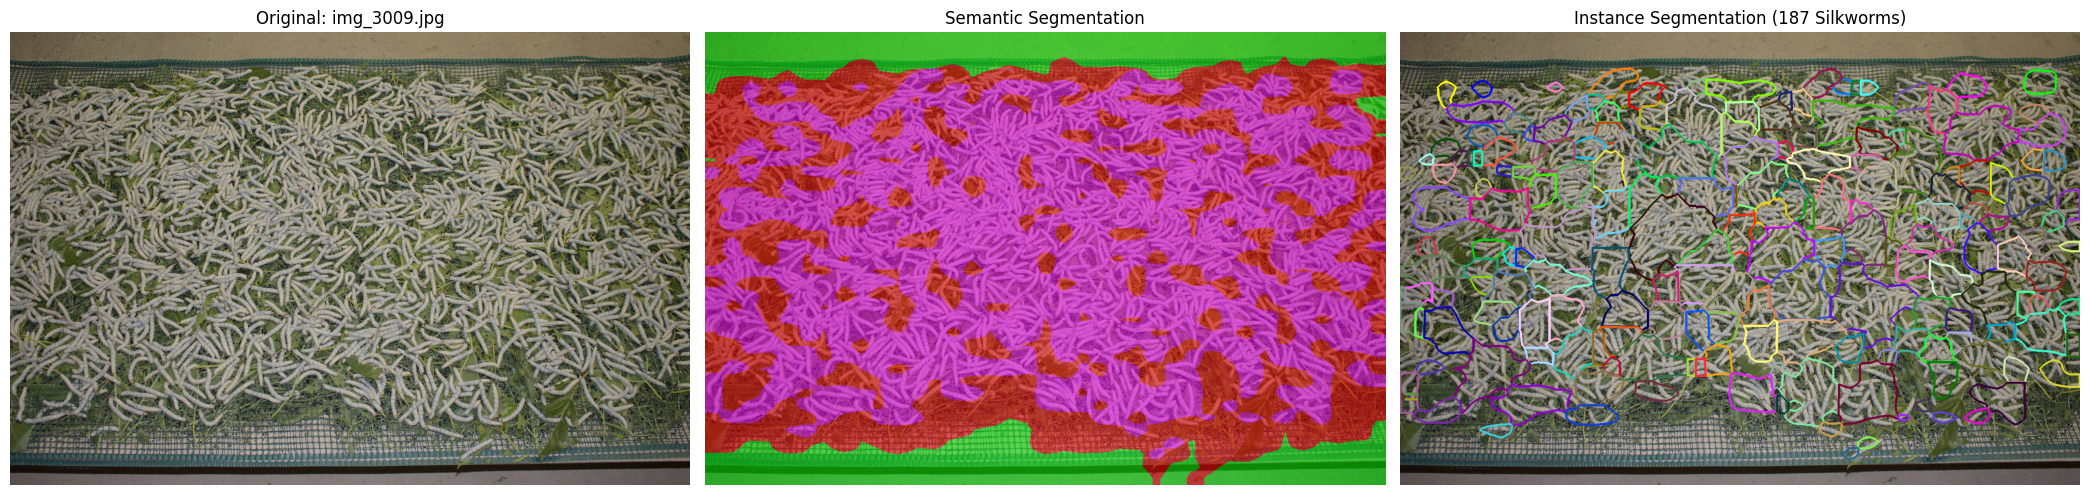


--- Evaluation Finished ---


In [9]:
# ===================================================================
# # 7. Evaluation
# This is the main execution block. It initializes the models and
# runs the full pipeline on the list of specified test images.
# ===================================================================
print("--- Starting Evaluation ---")

# --- Initialize Models ---
# Instantiate all the necessary classes for the pipeline
feature_extractor = DINOFeatureExtractor(device=DEVICE)
semantic_segmentor = SemanticSegmentation()
instance_segmentor = InstanceSegmentation()
main_pipeline = FinalPipeline(feature_extractor, semantic_segmentor, instance_segmentor)

# --- Run Pipeline on all Test Images ---
for filename in TEST_IMAGE_FILENAMES:
    image_path = os.path.join(DATASET_FOLDER, filename)

    if os.path.exists(image_path):
        print(f"\nProcessing image: {image_path}")
        
        # Run the full segmentation and counting process
        results = main_pipeline.run(image_path)
        
        # Print a summary of the results
        print(f"Total silkworm instances detected: {results['silkworm_count']}")
        print("Semantic labels assigned:", results['label_to_name_map'])
        
        # Display the visual results
        plot_segmentation_visualization(image_path, results)
    else:
        print(f"\nError: The image '{filename}' was not found in '{DATASET_FOLDER}'.")
        print("Please ensure the file exists and the name is correct.")

print("\n--- Evaluation Finished ---")